In [1]:
import sys
sys.path.append('../src/')
import importlib
from matplotlib import pylab as plt
%matplotlib inline 

import numpy as np
import torch
import torchvision

import cifar_data
import resnet18
import module2graph
import utils
import dartslike
importlib.reload(utils)
importlib.reload(module2graph)
importlib.reload(dartslike)


<module 'dartslike' from '/home/legin/reps/fast_nas_adapt/notebooks/../src/dartslike.py'>

In [2]:
class LowRankLinear(torch.nn.Module):
    def __init__(self, in_, out_, dim=1):
        super().__init__()
        self.l = torch.nn.Parameter(torch.randn(in_, dim)*1e-3)
        self.r = torch.nn.Parameter(torch.randn(dim, out_) * 1e-3)
    
    def forward(self, x):
        #print (x.shape, self.l.shape, self.r.shape)
        return x@self.l@self.r
    

In [3]:
batch_size = 64
device = 'cpu'
trial_num = 1
epoch_num = 1
lr = 1e-3
batch_seen = 5

In [4]:
trainloader, valloader, testloader = cifar_data.get_dataloaders([8,9], batch_size=batch_size, need_val=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = resnet18.ResNet18(8).to(device)
model.load_state_dict(torch.load('../data/model_last.ckpt', map_location=device))
model.model.fc = torch.nn.Linear(512, 2)
model = module2graph.GraphInterperterWithBernGamma(model, 1.0)

Using cache found in /home/legin/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
layer_names = list(model.forward(torch.randn(64, 3, 33, 33), intermediate=True)[1].keys())
sizes = {}
for k,v in model(torch.randn(64, 3, 33, 33), intermediate=True)[1].items():
    sizes[k] = v.shape
layer_names = [k for k in layer_names if k not in ['flatten', 'x']]
layer_names = ['model_fc']

In [7]:
class Aux(torch.nn.Module):
    def __init__(self, sizes, layer_names):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layer_names = layer_names
        self.means_int = {}
        self.lsigmas_int = {}
        self.means_y = {}
        self.lsigmas_y = {}
        
        for i in range(len(layer_names)-1):
            current = layer_names[i]
            next_ = layer_names[i+1]
            mat_size = np.prod(sizes[current][1:]) * np.prod(sizes[next_][1:])
            if mat_size>1024*1024:
                linear = LowRankLinear(np.prod(sizes[current][1:]), np.prod(sizes[next_][1:]))
            else:
                linear = torch.nn.Linear(np.prod(sizes[current][1:]), np.prod(sizes[next_][1:]))
            
            lsigma = torch.nn.Parameter(torch.tensor(-2.0))
            self.means_int[current] = linear
            self.lsigmas_int[current] = lsigma
            self.layers.append(linear)
            
        for i in range(len(layer_names)):
            current = layer_names[i]
            linear = torch.nn.Linear(np.prod(sizes[current][1:]), 2)
            lsigma = torch.nn.Parameter(torch.tensor(-2.0))
            self.means_y[current] = linear
            self.lsigmas_y[current] = lsigma
            self.layers.append(linear)
            


        
                                        

In [8]:
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            print (parameter_opt_type, gamma_opt_type, lam)

MI MI 1.0
MI MI 0.75
MI MI 0.5
MI MI 0.25
MI MI 0.0
MI CE 1.0
MI CE 0.75
MI CE 0.5
MI CE 0.25
MI CE 0.0
CE MI 1.0
CE MI 0.75
CE MI 0.5
CE MI 0.25
CE MI 0.0
CE CE 1.0
CE CE 0.75
CE CE 0.5
CE CE 0.25
CE CE 0.0


In [9]:
!ls -lh --sort=time

total 504K
-rw-rw-r-- 1 legin legin 229K дек 25 17:59 dartslike_mi.ipynb
-rw-rw-r-- 1 legin legin  664 дек 25 17:58 MI.MI.0.5.pckl
-rw-rw-r-- 1 legin legin  662 дек 25 17:55 MI.MI.0.75.pckl
-rw-rw-r-- 1 legin legin  664 дек 25 17:52 MI.MI.1.0.pckl
-rw-rw-r-- 1 legin legin  40K дек 25 17:50 dartslike.ipynb
-rw-rw-r-- 1 legin legin 126K дек  6 00:21 random_prune.ipynb
-rw-rw-r-- 1 legin legin  74K дек  5 23:48 full_model_from_scratch.ipynb
-rw-rw-r-- 1 legin legin 8,5K ноя 20 19:18 out
drwxrwxr-x 3 legin legin 4,0K ноя 20 18:26 data


MI.MI.1.0
MI.MI.0.75
MI.MI.0.5
MI.MI.0.25
MI.MI.0.0
MI.CE.1.0
MI.CE.0.75
MI.CE.0.5
MI.CE.0.25
MI.CE.0.0
CE.MI.1.0
CE.MI.0.75
CE.MI.0.5


Using cache found in /home/legin/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5325000286102295


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.6769999861717224


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8324999809265137


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8399999737739563


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.7760000228881836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8224999904632568


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.7735000252723694


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8130000233650208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.765999972820282


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8385000228881836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8199999928474426


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8450000286102295


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8899999856948853


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.5 (tensor(0.8333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.25


Using cache found in /home/legin/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7620000243186951


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8565000295639038


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8755000233650208


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8709999918937683


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.8974999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.9070000052452087


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.8725000023841858


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8485000133514404


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.890999972820282


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.9010000228881836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.9085000157356262


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.25 (tensor(0.7167), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.MI.0.0


Using cache found in /home/legin/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5619999766349792


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.7409999966621399


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8220000267028809


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8379999995231628


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.796999990940094


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.7415000200271606


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.809499979019165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.9079999923706055


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.8974999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.8019999861717224


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8234999775886536


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8895000219345093


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.MI.0.0 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
CE.CE.0.0


Using cache found in /home/legin/.cache/torch/hub/pytorch_vision_v0.10.0


0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.7450000047683716


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.8705000281333923


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.8744999766349792


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.8824999928474426


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.8920000195503235


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.906499981880188


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.8884999752044678


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.9039999842643738


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.9179999828338623


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.9010000228881836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.8974999785423279


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.8320000171661377


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 5. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 10. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 15. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 20. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 25. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 30. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 35. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 40. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 45. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 50. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 55. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 60. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 65. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 70. Accuracy: 0.5


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0. Batch seen: 75. Accuracy: 0.5
CE.CE.0.0 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])


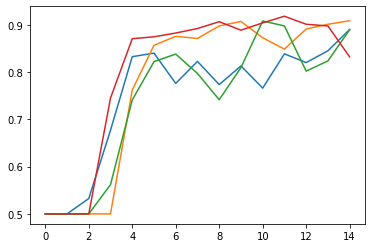

In [8]:
import pickle
import os
import gc
res = {}
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            
            if gamma_opt_type == 'CE' and parameter_opt_type == 'CE' and lam != 0.0:
                continue
            name = f'{parameter_opt_type}.{gamma_opt_type}.{lam}'
            print (name)
            if os.path.exists(name+'.pckl'):
                continue
            model = resnet18.ResNet18(8).to(device)
            aux = Aux(sizes, layer_names)
            model.load_state_dict(torch.load('../data/model_last.ckpt', map_location=device))
            model.model.fc = torch.nn.Linear(512, 2)
            model = module2graph.GraphInterperterWithBernGamma(model, 1.0)
            importlib.reload(dartslike)
            dl = dartslike.DartsLikeTrainer(model, parameter_optimization=parameter_opt_type, gamma_optimization=gamma_opt_type,
                                            aux=aux,MI_Y_lambda=lam)
            history = dl.train_loop(trainloader, valloader, testloader, batch_seen, epoch_num, 1e-3, 1e-3, device, 1e-6, )
            
            plt.plot(history, label=lam)
            model.make_gammas_discrete()
            model.discrete = True
            history2 = utils.train_loop(model, trainloader, testloader, batch_seen, epoch_num, lr, device)
            res[name] =  (model.gammas.mean(), history2)
            print (name, res[name])
            with open(name+'.pckl','wb') as out:
                out.write(pickle.dumps( (res[name], history)))
            del model
            del aux
            gc.collect()

MI.MI.1.0 (tensor(0.8333), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.75 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.5 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.25 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.MI.0.0 (tensor(0.7667), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.1.0 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.75 (tensor(0.8833), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.5 (tensor(0.7500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.25 (tensor(0.8500), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
MI.CE.0.0 (tensor(0.8000), [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

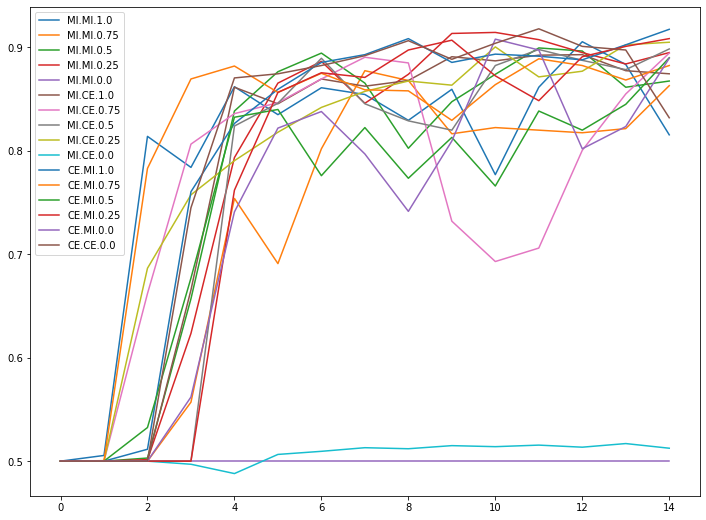

In [9]:
plt.rcParams['figure.figsize'] = (12, 9)
for parameter_opt_type in ['MI', 'CE']:
    for gamma_opt_type in ['MI', 'CE']:
        for lam in [0.0, 0.25, 0.5, 0.75, 1.0][::-1]:
            
            if gamma_opt_type == 'CE' and parameter_opt_type == 'CE' and lam != 0.0:
                continue
            name = f'{parameter_opt_type}.{gamma_opt_type}.{lam}'
            with open(name+'.pckl', 'rb') as inp:
                result, history = pickle.loads(inp.read())
                print (name, result)
                plt.plot(history, label=name)
plt.legend(loc='best')